# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Loading the banana dataset from OpenML

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10, length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = sign.(y .- 0.5)

50-element Vector{Float64}:
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
  ⋮
  1.0
 -1.0
 -1.0
  1.0
  1.0
 -1.0
 -1.0
  1.0
 -1.0

### We create a function to visualize the data

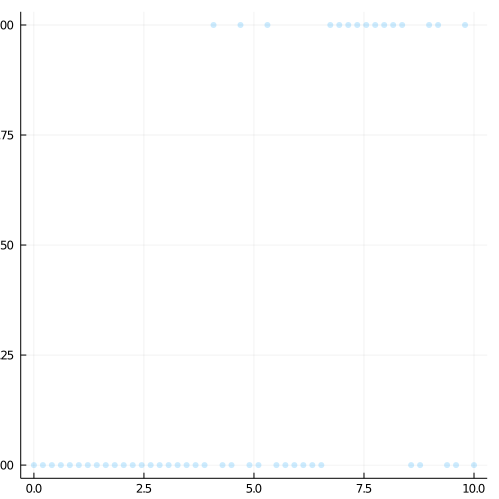

In [3]:
function plot_data(x, y; size=(300,500))
    Plots.scatter(x,
                y,
                alpha=0.2,
                markerstrokewidth=0.0,
                lab="",
                size=size
            )
end
plot_data(x, y; size = (500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign,
            kernel,
            LogisticLikelihood(),
            AnalyticVI(),
            optimiser = false
            )
@time train!(mfull, 5)

[ Info: Running full model
  0.653518 seconds (1.14 M allocations: 66.553 MiB, 99.30% compilation time)


### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y,
            kernel,
            LogisticLikelihood(),
            GibbsSampling(),
            optimiser = false
            )
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:05:52
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:59
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:59
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:29
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:11
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:59
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:50
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:44
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:39
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:35
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:32
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:29
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[-1.6833501240445408, -1.8659706539001384, -2.038281717130571, -2.211010872642713, -2.432816970312911, -2.697596728969212, -3.075469364289318, -3.518925417839977, -4.014001823384556, -4.475185110719142  …  1.8375717241370682, 1.5984852997574546, 1.267372527239788, 0.8629817781129326, 0.4605129144206109, 0.11683406395982568, -0.1223518642222357, -0.26971160090626856, -0.30901632129407, -0.26555195210950583]]
 [[-0.3100633785313426, -0.43120547667525533, -0.5252396926037415, -0.6458322158153956, -0.7278300790345363, -0.7596253636915, -0.8202621535706864, -0.9369128022389979, -1.1375631744138404, -1.3787592686138237  …  0.7631313204567729, 0.5304583569361654, 0.22115295557733616, -0.06395766559189436, -0.35855939446282414, -0.5809172788348383, -0.6444346029956454, -0.6140489082391161, -0.45689527940300145, -0.16730449925127747]]
 [[-0.8498899595313427, -0.7164208587581101, -0.6083290514887912, -0.5881702792126606, -0.6452617206377614, -0.786

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

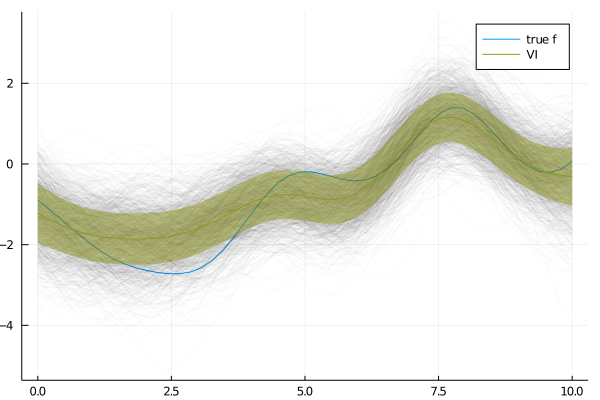

In [6]:
p1 = plot(x, f, label="true f")
plot!(x, samples, label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]), ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

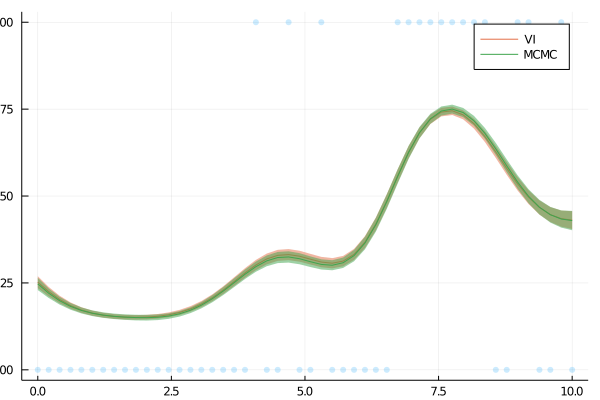

In [7]:
p2 = plot_data(x, y; size=(600,400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*